In [ ]:
#import library
import sys, os, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib

print("Versions:")
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)


Versions:
Python: 3.13.5
pandas: 2.2.3
numpy: 2.1.3
scikit-learn: 1.6.1


In [17]:
#Configuration 
DATA_PATH = (r"C:\Users\mohod\OneDrive\Documents\cardio_train (1).csv")   
TARGET_COL = "cardio"         


DROP_DUPLICATES = True
HANDLE_OUTLIERS = True  # Uses IQR rule for numeric columns
TEST_SIZE = 0.2
RANDOM_STATE = 42

print("Configured DATA_PATH:", DATA_PATH)
print("Configured TARGET_COL:", TARGET_COL)


Configured DATA_PATH: C:\Users\mohod\OneDrive\Documents\cardio_train (1).csv
Configured TARGET_COL: cardio


In [ ]:
#Load Dataset
def _demo_dataset(n=500, random_state=0):
    
    
    rng = np.random.default_rng(random_state)
    age = rng.integers(29, 77, size=n)
    trestbps = rng.integers(90, 200, size=n)         # resting blood pressure
    chol = rng.integers(100, 400, size=n)            # serum cholestoral
    thalach = rng.integers(70, 210, size=n)          # max heart rate
    oldpeak = rng.normal(1.0, 1.0, size=n).clip(0, 6) # ST depression induced by exercise
    sex = rng.integers(0, 2, size=n)                 # binary
    cp = rng.integers(0, 4, size=n)                  # chest pain type
    fbs = rng.integers(0, 2, size=n)                 # fasting blood sugar
    restecg = rng.integers(0, 2, size=n)             # resting electrocardiographic results
    exang = rng.integers(0, 2, size=n)               # exercise induced angina
    slope = rng.integers(0, 3, size=n)               # slope of peak exercise ST segment
    ca = rng.integers(0, 5, size=n)                  # number of major vessels (0–4, allow 4+ as noise)
    thal = rng.integers(0, 4, size=n)                # thalassemia (encoded)
    # A simple synthetic rule for target
    target = ((age > 50).astype(int) + (chol > 250).astype(int) + (exang==1).astype(int) + (oldpeak>2).astype(int)) > 1
    target = target.astype(int)

    df = pd.DataFrame({
        "age": age, "trestbps": trestbps, "chol": chol, "thalach": thalach, "oldpeak": oldpeak,
        "sex": sex, "cp": cp, "fbs": fbs, "restecg": restecg, "exang": exang, "slope": slope, "ca": ca, "thal": thal,
        "target": target
    })
    return df

if os.path.exists(DATA_PATH):
    
    df = pd.read_csv(DATA_PATH, sep=";")
    print(f"Loaded dataset from {DATA_PATH} with shape:", df.shape)
else:
    print(f"⚠️ File '{DATA_PATH}' not found. Using demo dataset.")
    df = _demo_dataset()
    print("Demo dataset shape:", df.shape)

df.head()


Loaded dataset from C:\Users\mohod\OneDrive\Documents\cardio_train (1).csv with shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
#Data Overview
print("Info:")
print(df.info())

print("\nDescribe (numeric):")
display(df.describe())

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

if DROP_DUPLICATES:
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    print(f"\nDropped {before - after} duplicate rows (if any). Current shape: {df.shape}")


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 1 columns):
 #   Column                                                                             Non-Null Count  Dtype 
---  ------                                                                             --------------  ----- 
 0   id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio  70000 non-null  object
dtypes: object(1)
memory usage: 547.0+ KB
None

Describe (numeric):


,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
count,70000
unique,70000
top,99974;19652;1;165;72.0;120;80;1;1;0;0;1;0
freq,1



Missing values per column:
id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio    0
dtype: int64

Dropped 0 duplicate rows (if any). Current shape: (70000, 1)


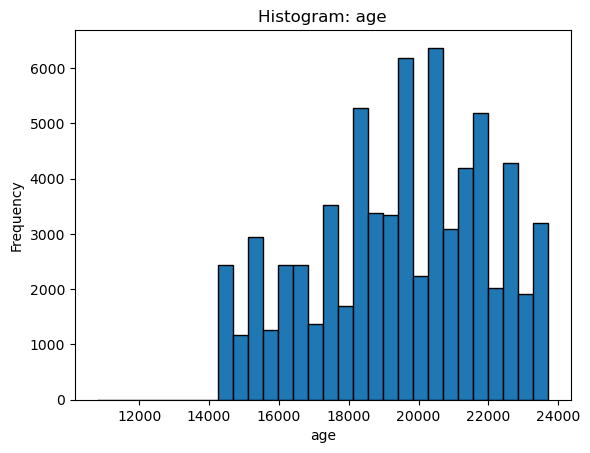

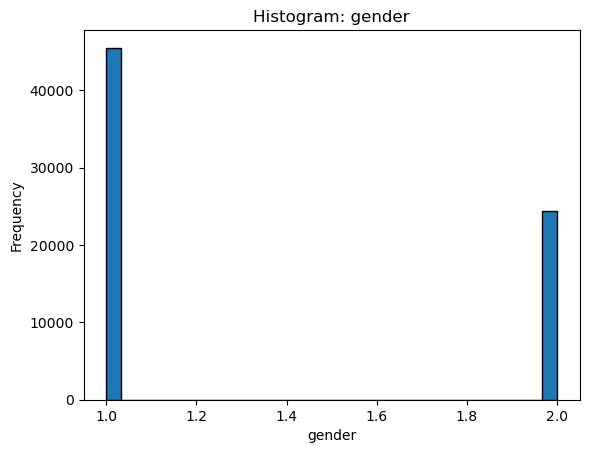

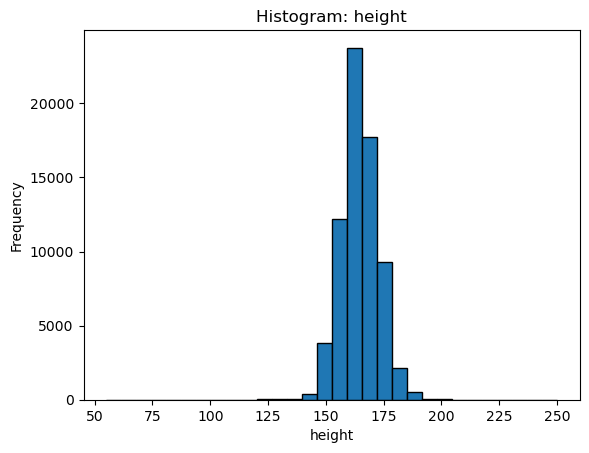

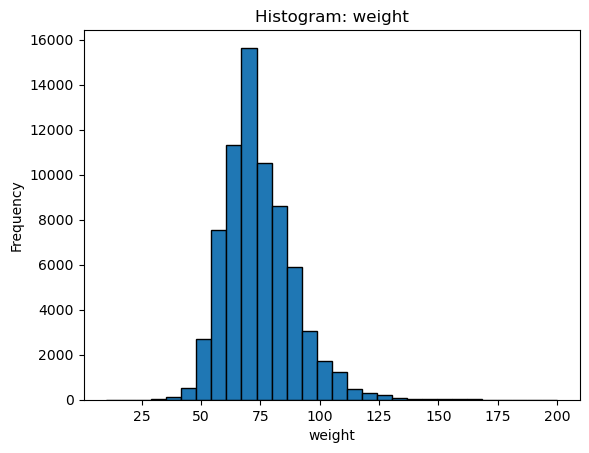

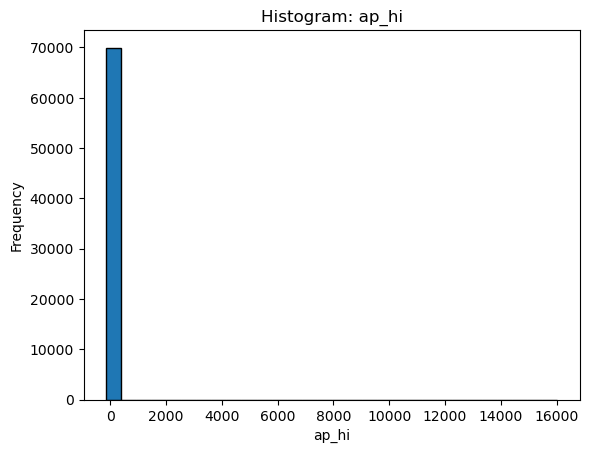

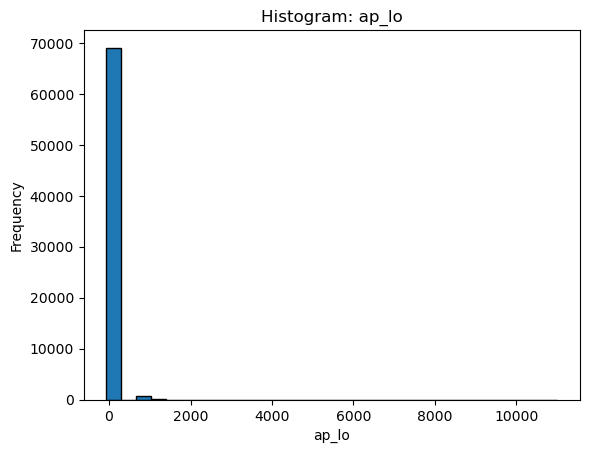

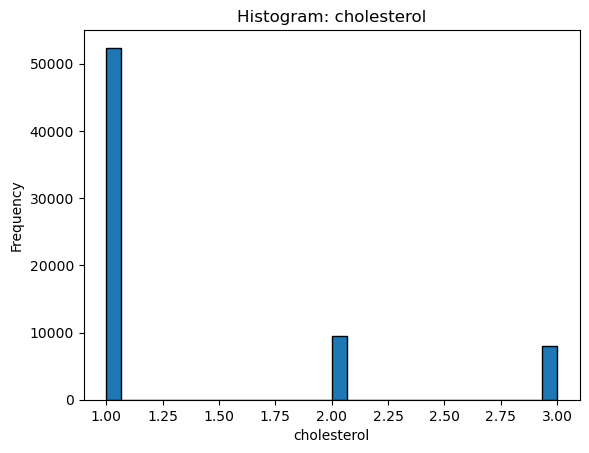

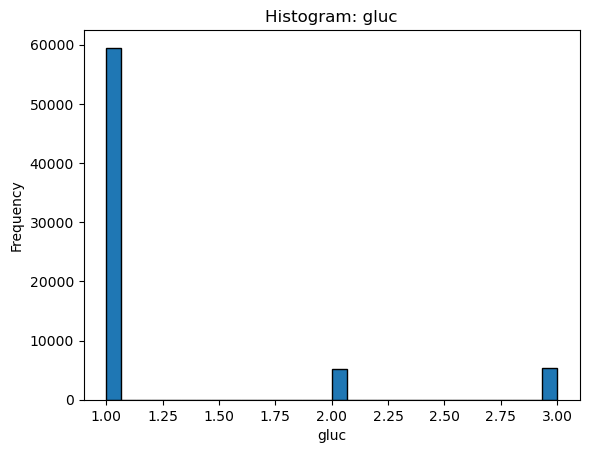

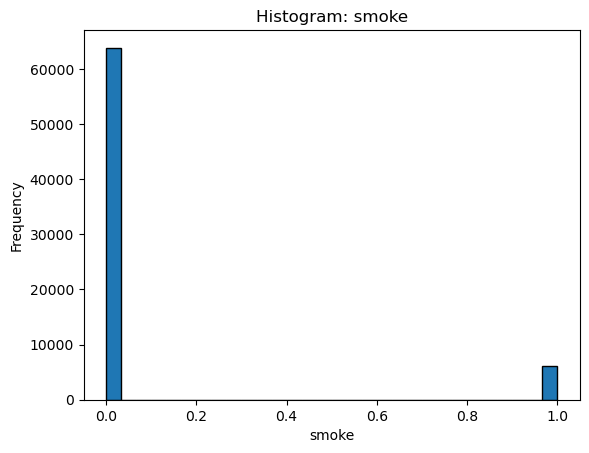

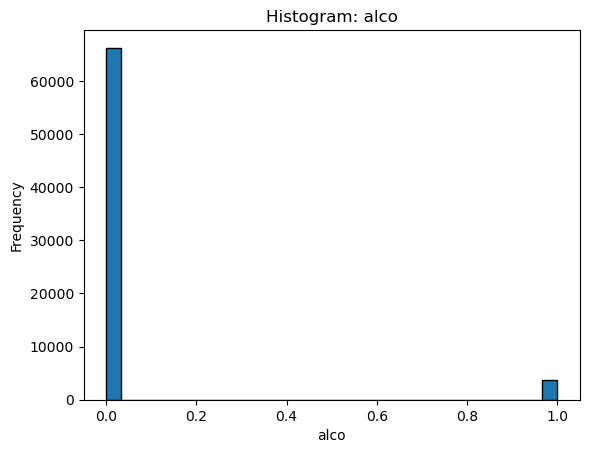

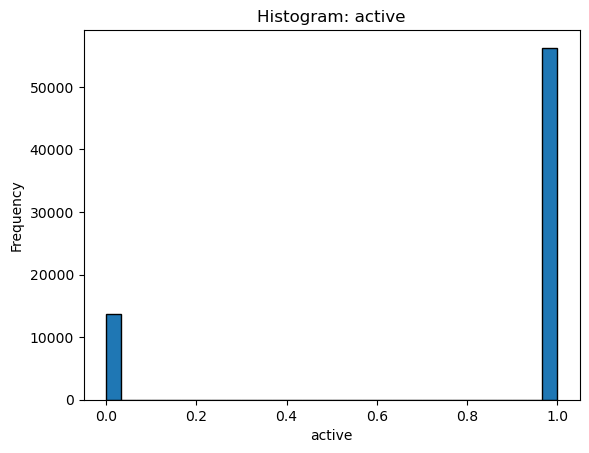

In [21]:
#EDA: Histograms
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                if col not in [TARGET_COL, "id"]]

for col in numeric_cols:
    plt.figure()
    df[col].dropna().plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


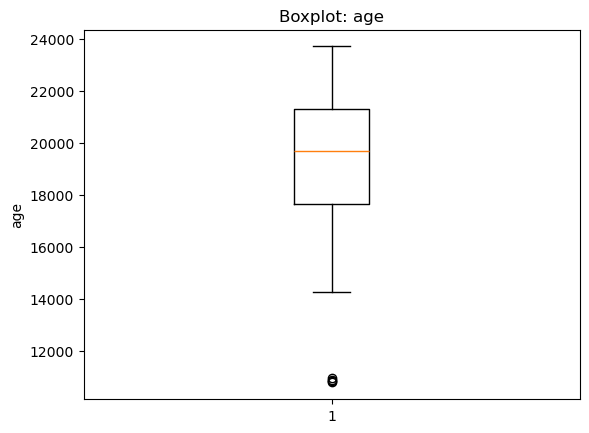

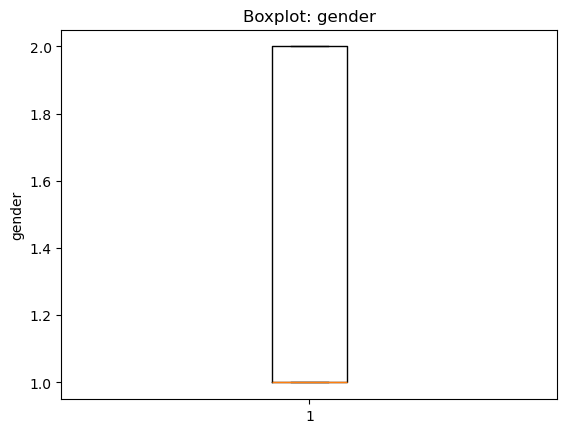

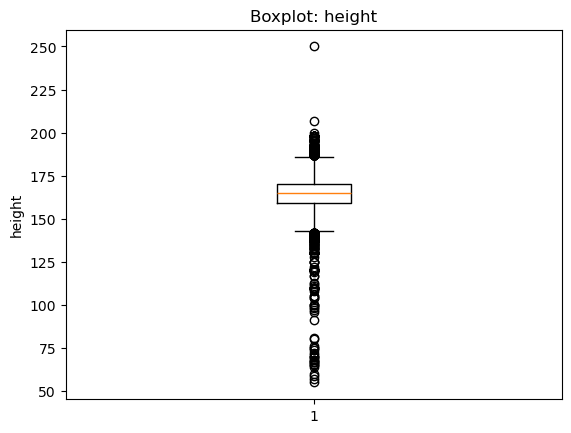

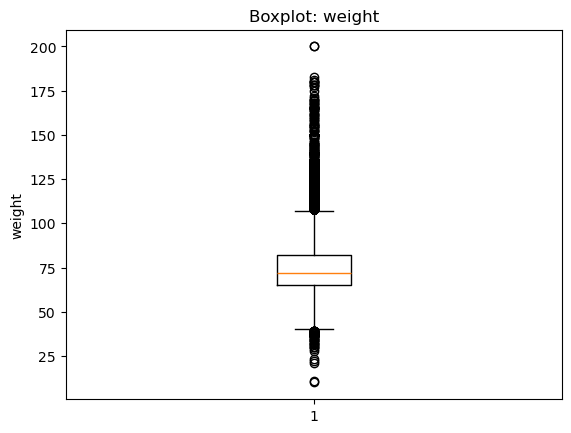

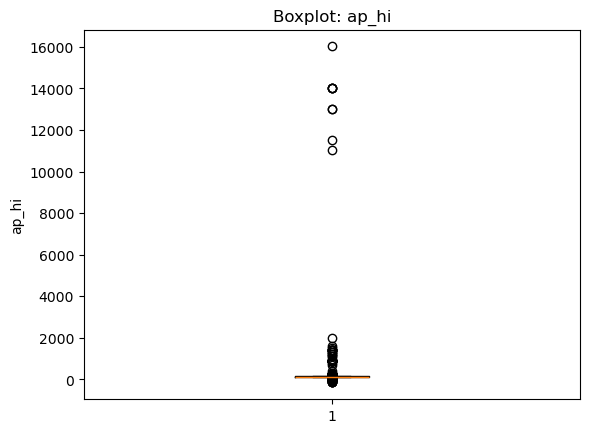

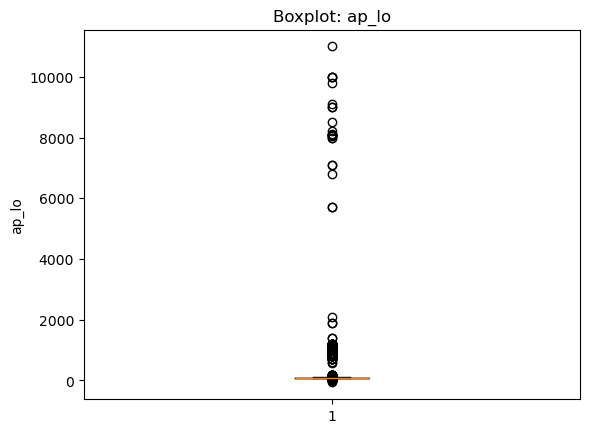

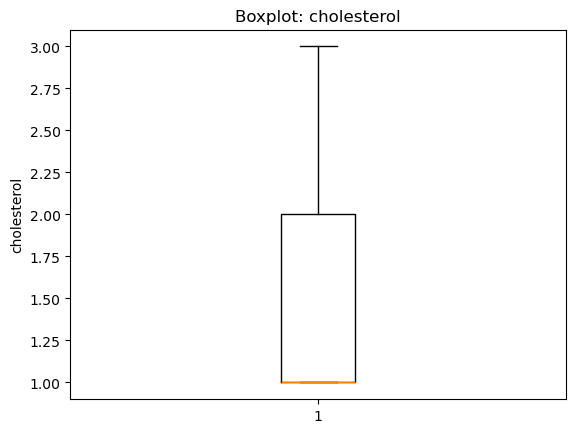

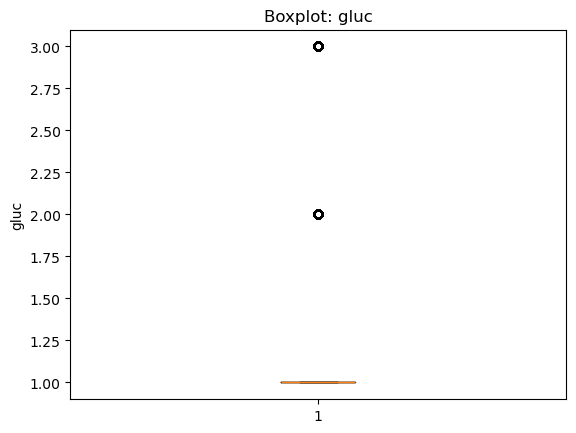

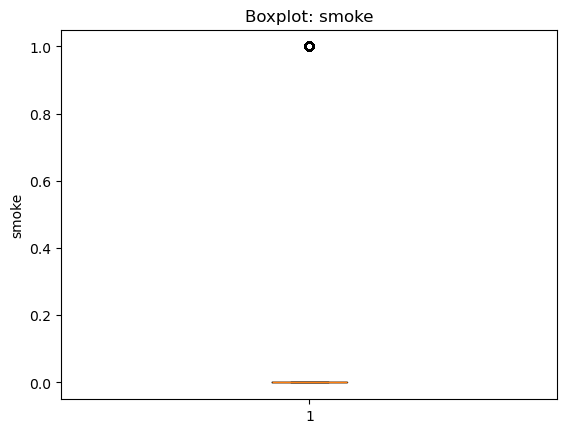

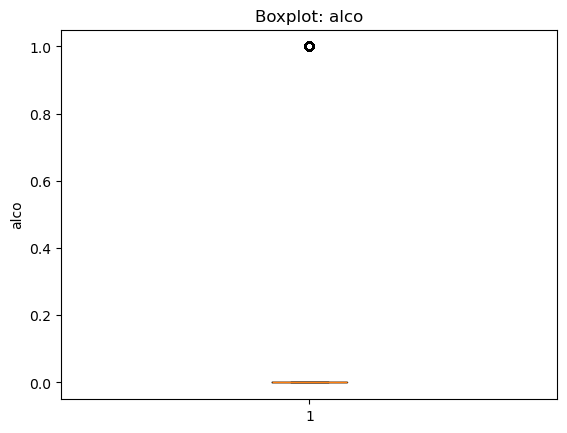

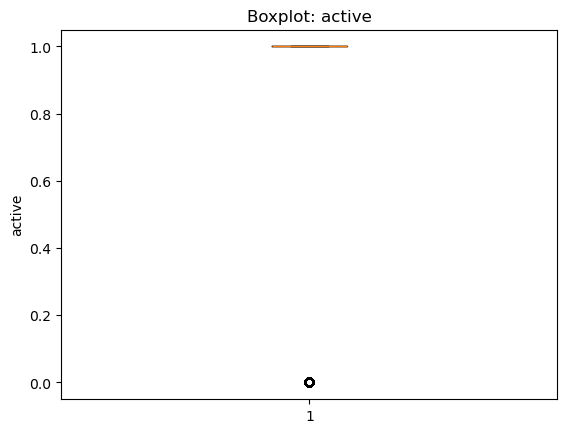

In [22]:
#EDA: Boxplots
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.show()


In [ ]:
#Handle Outliers (IQR rule)
if HANDLE_OUTLIERS:
    df_clean = df.copy()
    for col in numeric_cols:
        if col == TARGET_COL:
            continue
        series = df_clean[col].dropna()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        df_clean[col] = df_clean[col].clip(lower, upper)
    print("Outliers clipped using IQR rule. Shape:", df_clean.shape)
else:
    df_clean = df.copy()

df = df_clean


Outliers clipped using IQR rule. Shape: (70000, 1)


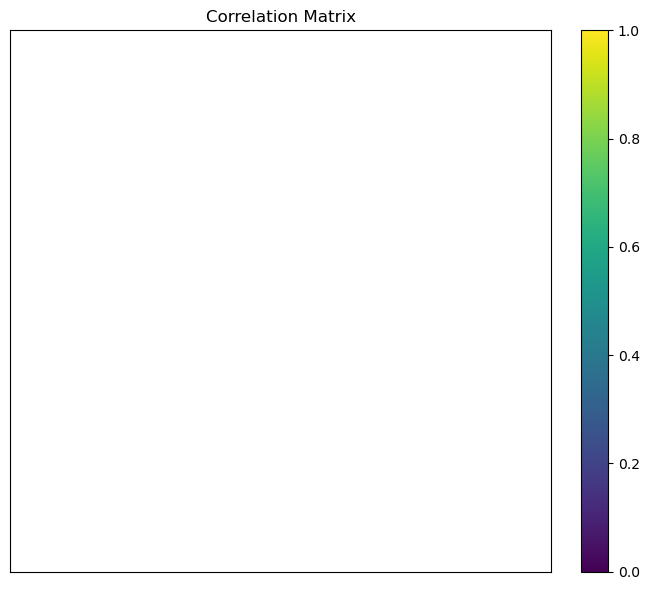

""


In [15]:
#Correlation Matrix
corr = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
plt.figure(figsize=(8, 6))
im = plt.imshow(corr.values, interpolation="nearest")
plt.title("Correlation Matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

corr

In [23]:
#Train/Test Split & Preprocessing
assert TARGET_COL in df.columns, f"TARGET_COL '{TARGET_COL}' not found in columns: {df.columns.tolist()}"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y if len(np.unique(y))<=20 else None
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Train shape: (56000, 12) Test shape: (14000, 12)
Numeric features: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
Categorical features: []


In [25]:
#Baseline: Logistic Regression
baseline_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)
y_proba_base = None
try:
    y_proba_base = baseline_clf.predict_proba(X_test)[:, 1]
except Exception:
    pass

base_results = {
    "accuracy": accuracy_score(y_test, y_pred_base),
    "precision": precision_score(y_test, y_pred_base, zero_division=0),
    "recall": recall_score(y_test, y_pred_base, zero_division=0),
    "f1": f1_score(y_test, y_pred_base, zero_division=0),
}
if y_proba_base is not None and len(np.unique(y))==2:
    base_results["roc_auc"] = roc_auc_score(y_test, y_proba_base)

print("Baseline (LogReg) metrics:", json.dumps(base_results, indent=2))


Baseline (LogReg) metrics: {
  "accuracy": 0.7136428571428571,
  "precision": 0.7315144938769184,
  "recall": 0.6745283018867925,
  "f1": 0.7018665873429017,
  "roc_auc": 0.7780957642761679
}


In [5]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Random seed
RANDOM_STATE = 42

# Create synthetic dataset 
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_classes=2, random_state=RANDOM_STATE)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
y = pd.Series(y, name="target")

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Preprocessing pipeline
numeric_features = X.columns.tolist()
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features)
])

# Sampling for speed
SAMPLE_SIZE = 5000
X_sample = X_train.sample(SAMPLE_SIZE, random_state=RANDOM_STATE) if len(X_train) > SAMPLE_SIZE else X_train
y_sample = y_train.loc[X_sample.index]

# Models to compare
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel="linear", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE)
}

# Train and evaluate
results = []
best_estimators = {}

for name, estimator in models.items():
    print(f"▶ Training {name} ...")
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("clf", estimator)])
    pipe.fit(X_sample, y_sample)
    best_estimators[name] = pipe

    y_pred = pipe.predict(X_test)
    row = {
        "model": name,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_precision": precision_score(y_test, y_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_pred, zero_division=0),
        "test_f1": f1_score(y_test, y_pred, zero_division=0),
    }
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
        row["test_roc_auc"] = roc_auc_score(y_test, y_proba)
    except Exception:
        pass
    results.append(row)
    print(f"✅ Finished {name}")

# Results summary
results_df = pd.DataFrame(results).sort_values(by="test_accuracy", ascending=False).reset_index(drop=True)
print(results_df)


▶ Training LogisticRegression ...
✅ Finished LogisticRegression
▶ Training SVM ...
✅ Finished SVM
▶ Training KNN ...
✅ Finished KNN
▶ Training DecisionTree ...
✅ Finished DecisionTree
▶ Training RandomForest ...
✅ Finished RandomForest
                model  test_accuracy  test_precision  test_recall   test_f1  \
0        RandomForest         0.9105        0.929387     0.889662  0.909091   
1                 KNN         0.8830        0.875486     0.894632  0.884956   
2        DecisionTree         0.8240        0.838509     0.805169  0.821501   
3                 SVM         0.8175        0.843516     0.782306  0.811759   
4  LogisticRegression         0.8150        0.829193     0.796223  0.812373   

   test_roc_auc  
0      0.968333  
1      0.946665  
2      0.893012  
3      0.898549  
4      0.899586  


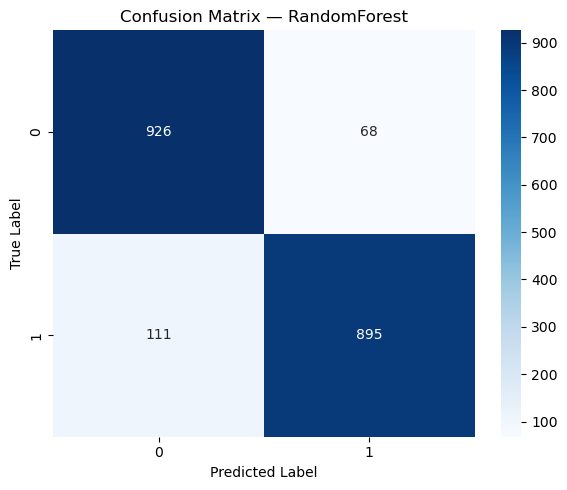

array([[926,  68],
       [111, 895]])

In [7]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure results are available
assert not results_df.empty, "No results to display."

#  Get the top-performing model
top_model_name = results_df.loc[0, "model"]
top_estimator = best_estimators[top_model_name]

#  Predict and compute confusion matrix
y_pred_top = top_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_pred_top)

# Plot using seaborn for better visuals
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f"Confusion Matrix — {top_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Return the matrix for inspection
cm


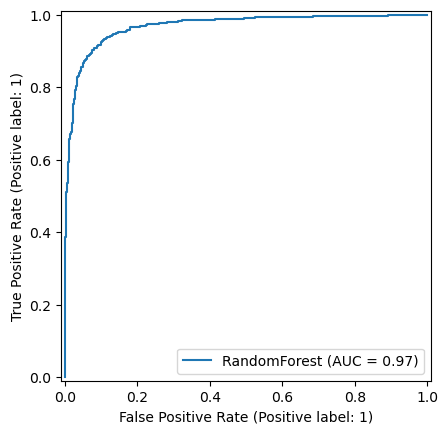

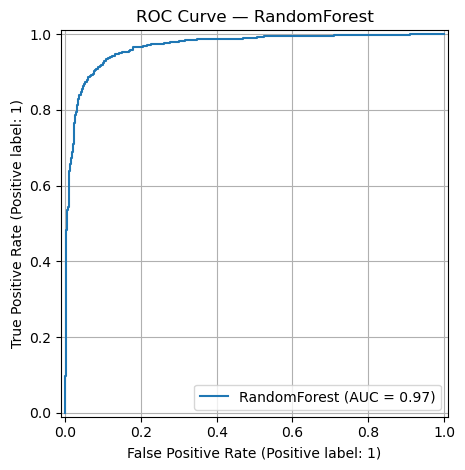

In [9]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


assert not results_df.empty, "No results to display."

# Get the top-performing model
top_model_name = results_df.loc[0, "model"]
top_estimator = best_estimators[top_model_name]

#  Predict probabilities (for ROC curve)
try:
    y_proba_top = top_estimator.predict_proba(X_test)[:, 1]

    # 🎨 Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba_top, name=top_model_name).plot()
    plt.title(f"ROC Curve — {top_model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except AttributeError:
    print(f"⚠️ Could not plot ROC curve: '{top_model_name}' does not support predict_proba.")


In [11]:
# Required Imports
import os
import joblib


assert not results_df.empty, "No models trained — run the model comparison cell first."

# Select the top-performing model
top_model_name = results_df.loc[0, "model"]
final_model = best_estimators[top_model_name]

#  Define target column name 
TARGET_COL = "target"  

# Create save directory
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model and metadata
save_path = os.path.join(MODEL_DIR, "best_model.pkl")
joblib.dump({
    "pipeline": final_model,
    "feature_names": X.columns.tolist(),
    "target_col": TARGET_COL,
    "model_name": top_model_name,
    "metrics": results_df.loc[0].to_dict()
}, save_path)

# Confirmation
print("✅ Best model saved successfully!")
print("📂 File path:", save_path)
print("\n=== Best Model Summary ===")
print("🧠 Model:", top_model_name)
print("📊 Metrics (on test set):")
print(results_df.loc[0])


✅ Best model saved successfully!
📂 File path: models\best_model.pkl

=== Best Model Summary ===
🧠 Model: RandomForest
📊 Metrics (on test set):
model             RandomForest
test_accuracy           0.9105
test_precision        0.929387
test_recall           0.889662
test_f1               0.909091
test_roc_auc          0.968333
Name: 0, dtype: object


In [12]:
# Required Imports
import joblib
import numpy as np
import pandas as pd

#  Load saved model and metadata
def load_model(path="models/best_model.pkl"):
    meta = joblib.load(path)
    return meta["pipeline"], meta["feature_names"], meta["target_col"]

# Predict from a dictionary of feature values
def predict_from_dict(feat_dict, model_path="models/best_model.pkl"):
    pipeline, feature_names, target_col = load_model(model_path)

    # Build input DataFrame with correct column order
    X_row = {k: [feat_dict.get(k, np.nan)] for k in feature_names}
    X_df = pd.DataFrame(X_row)

    # Make prediction
    pred = pipeline.predict(X_df)[0]
    try:
        proba = pipeline.predict_proba(X_df)[0, 1]
    except Exception:
        proba = None

    return int(pred), (float(proba) if proba is not None else None)

# Smoke test using median values from training data

try:
    median_point = {c: (X[c].median() if c in X.columns else None) for c in X.columns}
    p, prob = predict_from_dict(median_point)
    print("✅ Smoke test prediction:", p, "| probability:", prob)
except NameError:
    print("⚠️ Variable 'X' is not defined. Please ensure your training data is loaded.")


✅ Smoke test prediction: 1 | probability: 0.5438065530277624


In [13]:
# Required Imports
import numpy as np
import pandas as pd

# Load model and metadata
pipeline, feature_names, target_col = load_model("models/best_model.pkl")

print("=== Cardiovascular Disease Prediction — Manual Input ===")
print("Provide values for each feature (press Enter to accept default shown in brackets).")

# Collect user input with defaults from training data
user_values = {}
for feat in feature_names:
    default_val = ""
    if 'X' in globals() and feat in X.columns:
        if pd.api.types.is_numeric_dtype(X[feat]):
            default_val = str(float(X[feat].median()))
        else:
            mode_val = X[feat].mode()
            default_val = str(mode_val.iloc[0]) if not mode_val.empty else ""
    raw = input(f"{feat} [{default_val}]: ").strip()
    if raw == "":
        raw = default_val
    try:
        val = int(raw) if raw.isdigit() else float(raw)
    except ValueError:
        val = raw  # keep as string for categorical features
    user_values[feat] = val

# Predict using the input dictionary
pred, proba = predict_from_dict(user_values)
label = "Disease" if pred == 1 else "No Disease"

# Display results
print(f"\nPrediction: {label}")
if proba is not None:
    print(f"Estimated probability of class 1 (disease): {proba:.4f}")


=== Cardiovascular Disease Prediction — Manual Input ===
Provide values for each feature (press Enter to accept default shown in brackets).


feature_0 [-0.003920668262200514]:  0.5
feature_1 [0.07735622850428198]:  -1.2
feature_2 [0.016143696375617696]:  0
feature_3 [0.2878351631455302]:  0.05
feature_4 [-0.4998678656821189]:  0.4
feature_5 [0.006024804483283736]:  0.009
feature_6 [0.0016467022930376392]:  0.89
feature_7 [0.6028815014001901]:  6.6
feature_8 [0.18182819788744548]:  4.5
feature_9 [-0.019372048036805024]:  4
feature_10 [-0.016656925898004445]:  6
feature_11 [-0.1285422814896382]:  2.2
feature_12 [0.021432011909222993]:  23
feature_13 [-0.5041786296649485]:  6.6
feature_14 [-0.534930546072536]:  0.5
feature_15 [0.04139091869271616]:  0.6
feature_16 [0.5592045750930266]:  9.6
feature_17 [0.49014246763993663]:  0.6
feature_18 [0.005860081938317108]:  0.3
feature_19 [0.004427323426300343]:  3.4



Prediction: No Disease
Estimated probability of class 1 (disease): 0.4563


In [14]:
# Required Imports
import os
import pandas as pd


assert 'results_df' in globals() and not results_df.empty, "results_df is missing or empty."

# Define output directory
OUT_DIR = "artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

# Save results to CSV
csv_path = os.path.join(OUT_DIR, "model_comparison.csv")
results_df.to_csv(csv_path, index=False)

# Confirmation and preview
print("✅ Saved model comparison table to:", csv_path)
print("\n📊 Top rows of model comparison:")
print(results_df.head())


✅ Saved model comparison table to: artifacts\model_comparison.csv

📊 Top rows of model comparison:
                model  test_accuracy  test_precision  test_recall   test_f1  \
0        RandomForest         0.9105        0.929387     0.889662  0.909091   
1                 KNN         0.8830        0.875486     0.894632  0.884956   
2        DecisionTree         0.8240        0.838509     0.805169  0.821501   
3                 SVM         0.8175        0.843516     0.782306  0.811759   
4  LogisticRegression         0.8150        0.829193     0.796223  0.812373   

   test_roc_auc  
0      0.968333  
1      0.946665  
2      0.893012  
3      0.898549  
4      0.899586  
